In [1]:
# 每个MDP，都有一套V*/Q*，有多个Pi*对应到值*
# 对于单个MDP，从不同Pi出发，可以达到不同的Pi*，但是值*唯一
# 不同Pi在MDP下都会有一套稳定的值V/Q

In [2]:
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py  # 左、下、右、上

# https://github.com/boyu-ai/Hands-on-RL

# https://zhuanlan.zhihu.com/p/468235479
# https://zhuanlan.zhihu.com/p/470994332
# https://zhuanlan.zhihu.com/p/473798126

# https://blog.csdn.net/jiebaoshayebuhui/article/details/128487283
# https://zhuanlan.zhihu.com/p/54936262

In [3]:
# 环境搭建：
# conda create -n RL_Basics
# conda activate RL_Basics

# conda install python=3.8

# https://pytorch.org/get-started/previous-versions/
# conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia



# conda install ipykernel
# conda install platformdirs
# pip3 install ipywidgets
# pip3 install --upgrade jupyter_core jupyter_client

# python -m ipykernel install --user --name RL_Basics

In [4]:
# pip install "gymnasium[all]"
# pip install swig

In [5]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import copy
import matplotlib.pyplot as plt  # https://matplotlib.org/stable/index.html#
import numpy as np
import random

In [6]:
###

In [7]:
def equiprobability_policy(env) :

    pi = np.ones( [env.observation_space.n, env.action_space.n] )  # 16x4

    pi = pi * (1/env.action_space.n)

    return pi

In [8]:
def episode_sample(env, pi) :

    obs, _ = env.reset()

    episode = []
    while True :
        timestep = []

        timestep.append(obs)

        action = np.random.choice(env.action_space.n, p=pi[obs])

        next_obs, reward, terminated, truncated, _ = env.step(action)

        timestep.append(action)
        timestep.append(reward)
        timestep.append(next_obs)
        episode.append(timestep)

        obs = next_obs

        if terminated or truncated :
            break

    return episode

In [9]:
###

In [10]:
def policy_evaluation_V(env, pi, epsilon=0.10, gamma=0.98, theta=1e-4) :

    old_V = np.zeros(env.observation_space.n)
    new_V = np.zeros(env.observation_space.n)

    old_Q = np.zeros( [env.observation_space.n, env.action_space.n] )
    new_Q = np.zeros( [env.observation_space.n, env.action_space.n] )

    cnt = 0
    while True :
        diff = 0

        for s in range(env.observation_space.n) :
            new_V[s] = 0

            for a in range(env.action_space.n) :
                new_Q[s, a] = 0

                # print(env.P[s][a])
                for p, s_next, r, done in env.P[s][a] :  # if s_next is done
                    new_Q[s, a] += p*(r+gamma*old_V[s_next]*(1-done))

                new_V[s] += pi[s, a]*new_Q[s, a]

            diff += np.abs(new_V[s] - old_V[s])
            old_V[s] = new_V[s]
        # old_V = new_V  # 直接赋值，精度不够？变量和变量的=，变化会同步

        cnt += 1

        if diff < theta :
            # print(cnt)
            break

    return old_V

In [11]:
def policy_evaluation_Q(env, pi, epsilon=0.10, gamma=0.98, theta=1e-4) :

    old_V = np.zeros(env.observation_space.n)
    new_V = np.zeros(env.observation_space.n)

    old_Q = np.zeros( [env.observation_space.n, env.action_space.n] )
    new_Q = np.zeros( [env.observation_space.n, env.action_space.n] )

    cnt = 0
    while True :
        diff = 0

        for s in range(env.observation_space.n) :
            new_V[s] = 0

            for a in range(env.action_space.n) :
                new_Q[s, a] = 0

                # print(env.P[s][a])
                for p, s_next, r, done in env.P[s][a] :  # if s_next is done
                        new_V[s_next] = 0

                        for a_next in range(env.action_space.n) :
                            new_V[s_next] += pi[s_next, a_next]*old_Q[s_next, a_next]

                        new_Q[s, a] += p*(r+gamma*new_V[s_next]*(1-done))

                diff += np.abs(new_Q[s, a] - old_Q[s, a])
                old_Q[s, a] = new_Q[s, a]

        for s in range(env.observation_space.n) :
            new_V[s] = 0
            for a in range(env.action_space.n) :
                new_V[s] += pi[s, a]*old_Q[s, a]
            old_V[s] = new_V[s]

        cnt += 1

        if diff < theta :
            # print(cnt)
            print(old_V)
            break

    return old_Q

In [12]:
def mc_evaluation_V(env, pi, n_episodes=100000, gamma=0.98) :

    new_V = np.zeros(env.observation_space.n)
    cnt_V = np.zeros(env.observation_space.n)

    for i in range(n_episodes) :

        episode = episode_sample(env, pi)
        G = 0

        for j in range( len(episode)-1, -1, -1 ) :  # range(i, j) == i ~ j-1

            (s, a, r, s_next) = episode[j]
            G = r + gamma*G

            cnt_V[s] = cnt_V[s] + 1
            new_V[s] = new_V[s] + (G - new_V[s])/cnt_V[s]

    return new_V

In [13]:
def mc_evaluation_Q(env, pi, n_episodes=100000, gamma=0.98) :

    new_Q = np.zeros( [env.observation_space.n, env.action_space.n] )
    cnt_Q = np.zeros( [env.observation_space.n, env.action_space.n] )

    for i in range(n_episodes) :

        episode = episode_sample(env, pi)
        G = 0

        for j in range( len(episode)-1, -1, -1 ) :  # range(i, j) == i ~ j-1

            (s, a, r, s_next) = episode[j]
            G = r + gamma*G

            cnt_Q[s, a] = cnt_Q[s, a] + 1
            new_Q[s, a] = new_Q[s, a] + (G - new_Q[s, a])/cnt_Q[s, a]

    return new_Q

In [14]:
def TD0_evaluation_V(env, pi, n_episodes=100000, gamma=0.98, alpha=0.05) :

    new_V = np.zeros(env.observation_space.n)

    for i in range(n_episodes) :
        episode = episode_sample(env, pi)

        for j in range( len(episode) ) :
            (s, a, r, s_next) = episode[j]  # expolit all the transitions
            new_V[s] += alpha*(r+gamma*new_V[s_next]-new_V[s])

    return new_V

In [15]:
def TDlambda_evaluation_V(env, pi, n_episodes=100000, gamma=0.98, TDlambda=0.98, alpha=0.05) :

    new_V = np.zeros(env.observation_space.n)
    new_T = np.zeros(env.observation_space.n)

    for i in range(n_episodes) :
        episode = episode_sample(env, pi)

        for j in range( len(episode) ) :
            (s, a, r, s_next) = episode[j]

            # 和transitions利用的顺序有关？短时间高强度访问，增大学习权重
            new_T = gamma*TDlambda*new_T
            new_T[s] += 1

            new_V[s] += alpha*(r+gamma*new_V[s_next]-new_V[s])*new_T[s]  # 放大了学习程度

    return new_V

In [16]:
###

In [17]:
def policy_improvement_greedy(env, Q) :

    new_pi = np.zeros( [env.observation_space.n, env.action_space.n] )

    maxQ = np.max(Q, axis=1)
    # print(maxQ)

    for s in range(env.observation_space.n) :
        q_cnt = 0

        for a in range(env.action_space.n) :
            if Q[s, a] == maxQ[s] :  # 至少有1
                q_cnt += 1

        for a in range(env.action_space.n) :
            if Q[s, a] == maxQ[s] :
                new_pi[s, a] = 1/q_cnt
            else :
                new_pi[s, a] = 0

    return new_pi

In [18]:
def policy_improvement_epsilon_greedy(env, Q, epsilon=0.10) :

    new_pi = np.zeros( [env.observation_space.n, env.action_space.n] )

    maxQ = np.max(Q, axis=1)
    # print(maxQ)

    for s in range(env.observation_space.n) :
        q_cnt = 0

        for a in range(env.action_space.n) :
            if Q[s, a] == maxQ[s] :  # 至少有1
                q_cnt += 1

        for a in range(env.action_space.n) :
            if Q[s, a] == maxQ[s] :
                new_pi[s, a] = epsilon/env.action_space.n + ( (1-epsilon)/q_cnt )
            else :
                new_pi[s, a] = epsilon/env.action_space.n

    return new_pi

In [19]:
###

In [20]:
def policy_iteration_1(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)  # https://blog.csdn.net/corner2030/article/details/126891322
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = policy_evaluation_Q(env, old_pi)
        # print(Q)
        # new_pi >= old_pi
        new_pi = policy_improvement_greedy(env, Q)
        # print(new_pi)

        # 在evaluation准确（Pi～Q），和improvement正确（Q～Pi）的条件下
        # 会生成Pi*（下一回合，Pi不再发生变化），Pi*会对应到值*

        # 是否存在值接近*，但是还没到值*，就improvement到Pi*（必然存在）
        # 此时，再对Pi*做evaluation，才可以得到值*

        # Pi～Q～Pi模式，检测Pi误差，确保了Pi*时的Q*

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [21]:
def mc_iteration_1(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = mc_evaluation_Q(env, old_pi)
        # print(Q)

        new_pi = policy_improvement_greedy(env, Q)
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [22]:
def policy_iteration_2(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = policy_evaluation_Q(env, old_pi)
        # print(Q)

        new_pi = policy_improvement_epsilon_greedy(env, Q)
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [23]:
def mc_iteration_2(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = mc_evaluation_Q(env, old_pi)
        # print(Q)

        new_pi = policy_improvement_epsilon_greedy(env, Q)
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [24]:
def policy_iteration_3(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = policy_evaluation_Q(env, old_pi)
        # print(Q)

        # print(max(epsilon/np.log(2*cnt), 4e-2))
        new_pi = policy_improvement_epsilon_greedy(env, Q, max(epsilon/np.log(2*cnt), 4e-2))
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [25]:
def mc_iteration_3(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = mc_evaluation_Q(env, old_pi)
        # print(Q)

        # print(max(epsilon/np.log(2*cnt), 4e-2))
        new_pi = policy_improvement_epsilon_greedy(env, Q, max(epsilon/np.log(2*cnt), 4e-2))
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [26]:
def policy_iteration_4(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = policy_evaluation_Q(env, old_pi)
        # print(Q)

        # print(max(epsilon/cnt, 4e-2))
        new_pi = policy_improvement_epsilon_greedy(env, Q, max(epsilon/cnt, 4e-2))
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [27]:
def mc_iteration_4(env, pi, epsilon=0.10, gamma=0.98, theta=1e-3) :

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)

    cnt = 0
    while True :
        cnt += 1

        diff = 0

        Q      = mc_evaluation_Q(env, old_pi)
        # print(Q)

        # print(max(epsilon/cnt, 4e-2))
        new_pi = policy_improvement_epsilon_greedy(env, Q, max(epsilon/cnt, 4e-2))
        # print(new_pi)

        diff = np.sum(np.abs(new_pi - old_pi))

        old_pi = new_pi

        if diff < theta :
            # print(cnt)
            break

    return old_pi

In [28]:
def value_iteration(env, pi, epsilon=0.10, gamma=0.98, theta=1e-4) :

    old_V  = np.zeros(env.observation_space.n)
    new_V  = np.zeros(env.observation_space.n)

    old_Q  = np.zeros( [env.observation_space.n, env.action_space.n] )
    new_Q  = np.zeros( [env.observation_space.n, env.action_space.n] )

    old_pi = copy.deepcopy(pi)
    new_pi = copy.deepcopy(pi)


    cnt = 0
    while True :
        diff = 0

        for s in range(env.observation_space.n) :
            new_V[s] = 0
            for a in range(env.action_space.n) :
                new_Q[s, a] = 0

                # print(env.P[s][a])
                for p, s_next, r, done in env.P[s][a] :  # if s_next is done
                    new_Q[s, a] += p*(r+gamma*old_V[s_next]*(1-done))

            new_V[s] = np.max(new_Q[s])

            diff += np.abs(new_V[s] - old_V[s])

            old_V[s] = new_V[s]

        cnt += 1

        if diff < theta :
            # print(cnt)
            break


    for s in range(env.observation_space.n) :
        for a in range(env.action_space.n) :
            new_Q[s, a] = 0

            # print(env.P[s][a])
            for p, s_next, r, done in env.P[s][a] :  # if s_next is done
                new_Q[s, a] += p*(r+gamma*old_V[s_next]*(1-done))
            old_Q[s, a] = new_Q[s, a]


    maxQ = np.max(old_Q, axis=1)
    # print(maxQ)
    for s in range(env.observation_space.n) :
        q_cnt = 0
        for a in range(env.action_space.n) :
            if old_Q[s, a] == maxQ[s] :
                q_cnt += 1

        for a in range(env.action_space.n) :
            if old_Q[s, a] == maxQ[s] :
                new_pi[s, a] = 1/q_cnt
            else :
                new_pi[s, a] = 0
            old_pi[s, a] = new_pi[s, a]


    print(old_V)
    print(old_Q)
    print(old_pi)

    return old_pi

In [29]:
###

In [30]:
def policy_test(env, pi, ite_num=10000, ite_len=100) :

    suc_cnt = 0
    for i in range(ite_num) :

        obs, _ = env.reset()

        for j in range(ite_len) :

            action = np.random.choice(env.action_space.n, p=pi[obs])

            obs, reward, terminated, truncated, _ = env.step(action)

            if terminated or truncated :
                if reward == 1 :
                    suc_cnt += 1
                break

    print(suc_cnt/ite_num)

    return suc_cnt/ite_num

In [31]:
###

In [32]:
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
# gym.make('FrozenLake-v1', desc=generate_random_map(size=8))

# obs, info = env.reset(seed=42)
obs, info = env.reset()
# print(obs)
# print(info)

pi = equiprobability_policy(env)
# print(pi)

In [33]:
print(policy_evaluation_V(env, pi))
print(mc_evaluation_V(env, pi))
print(TD0_evaluation_V(env, pi))
print(TDlambda_evaluation_V(env, pi))

/home/zhfc/anaconda3/envs/RL_Basics/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


[0.01090545 0.00932524 0.01785466 0.00857052 0.01344758 0.
 0.03714546 0.         0.03055149 0.08070846 0.13376113 0.
 0.         0.16511277 0.42811103 0.        ]
[0.01036974 0.00926105 0.01699835 0.00697293 0.01299591 0.
 0.03380924 0.         0.02866752 0.0807445  0.1258659  0.
 0.         0.16571608 0.41551439 0.        ]
[0.01216509 0.00763708 0.01333876 0.00684099 0.0165923  0.
 0.04100694 0.         0.02877193 0.10336959 0.14821332 0.
 0.         0.17295627 0.49138169 0.        ]
[0.00227371 0.00101243 0.02330994 0.012552   0.01315708 0.
 0.05184258 0.         0.02312715 0.11107064 0.17793885 0.
 0.         0.18452198 0.51007542 0.        ]


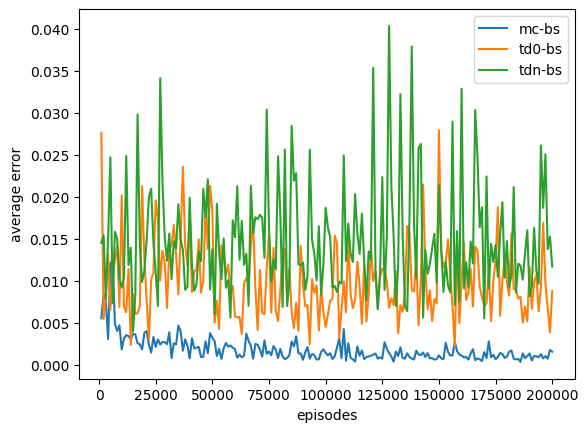

In [34]:
error21_avg = []
error31_avg = []
error41_avg = []


episodes_ary = np.arange(1000, 200001, 1000)
for epis in episodes_ary :

    V1 = policy_evaluation_V(env, pi)

    V2 = mc_evaluation_V(env, pi, epis)

    V3 = TD0_evaluation_V(env, pi, epis)

    V4 = TDlambda_evaluation_V(env, pi, epis)

    error21 = np.array(V2 - V1)
    error21_avg.append(np.mean(np.abs(error21)))

    error31 = np.array(V3 - V1)
    error31_avg.append(np.mean(np.abs(error31)))

    error41 = np.array(V4 - V1)
    error41_avg.append(np.mean(np.abs(error41)))


fig = plt.figure()
plt.plot(episodes_ary, error21_avg, label='mc-bs')
plt.plot(episodes_ary, error31_avg, label='td0-bs')
plt.plot(episodes_ary, error41_avg, label='tdn-bs')
plt.xlabel('episodes')
plt.ylabel('average error')
plt.legend()
plt.show()

In [35]:
print(policy_evaluation_Q(env, pi))
print(mc_evaluation_Q(env, pi))

policy_test(env, pi)

[0.01096009 0.00935631 0.01787748 0.00858729 0.01347337 0.
 0.03715225 0.         0.03056342 0.08071358 0.13376486 0.
 0.         0.16511586 0.42811353 0.        ]
[[0.0115566  0.01103426 0.01103476 0.01021472]
 [0.00663549 0.00941942 0.00889492 0.01247543]
 [0.02103166 0.01799717 0.02078033 0.01170077]
 [0.00864462 0.00864475 0.0056098  0.01145   ]
 [0.01796413 0.01438419 0.01356385 0.00798133]
 [0.         0.         0.         0.        ]
 [0.04953634 0.04369636 0.04953634 0.00583998]
 [0.         0.         0.         0.        ]
 [0.01438486 0.0363499  0.03076751 0.0407514 ]
 [0.06392175 0.10761811 0.09763406 0.05368041]
 [0.17835315 0.16621675 0.15198671 0.03850284]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08030414 0.19378805 0.22015451 0.16621675]
 [0.23748468 0.52712153 0.51688023 0.4309677 ]
 [0.         0.         0.         0.        ]]
[[0.01169553 0.01130971 0.01209049 0.01014743]
 [0.00702186 0.01024595 0.01032511 0

0.0151

In [36]:
policy_test(env, policy_iteration_1(env, pi))
policy_test(env, mc_iteration_1(env, pi))

policy_test(env, policy_iteration_2(env, pi))
policy_test(env, mc_iteration_2(env, pi))

policy_test(env, policy_iteration_3(env, pi))
policy_test(env, mc_iteration_3(env, pi))

policy_test(env, policy_iteration_4(env, pi))
policy_test(env, mc_iteration_4(env, pi))

policy_test(env, value_iteration(env, pi))

[0.01096009 0.00935631 0.01787748 0.00858729 0.01347337 0.
 0.03715225 0.         0.03056342 0.08071358 0.13376486 0.
 0.         0.16511586 0.42811353 0.        ]
[0.38655931 0.32726408 0.28801213 0.27139042 0.41024035 0.
 0.26639768 0.         0.45904558 0.53596085 0.52749231 0.
 0.         0.65416132 0.81241456 0.        ]
[0.38723996 0.33165816 0.29639141 0.27928163 0.41095803 0.
 0.26960606 0.         0.45984202 0.5368836  0.52893471 0.
 0.         0.65474707 0.8126988  0.        ]
0.7427
0.6351
[0.01096009 0.00935631 0.01787748 0.00858729 0.01347337 0.
 0.03715225 0.         0.03056342 0.08071358 0.13376486 0.
 0.         0.16511586 0.42811353 0.        ]
[0.23834959 0.20155444 0.19292647 0.16927086 0.25616099 0.
 0.19823702 0.         0.30976936 0.40666252 0.42948296 0.
 0.         0.53755553 0.74355624 0.        ]
0.416
0.4074
[0.01096009 0.00935631 0.01787748 0.00858729 0.01347337 0.
 0.03715225 0.         0.03056342 0.08071358 0.13376486 0.
 0.         0.16511586 0.42811353 0

0.7375

In [37]:
env.close()